# Data Exploration

In [1]:
# import libraries

import pandas as pd
import numpy as np
import math as m
from ast import literal_eval
import itertools
import re


from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (VotingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier
                             )
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score,
                             precision_recall_curve,
                             make_scorer,
                             confusion_matrix,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report,
                             roc_curve,
                             auc,
                             plot_precision_recall_curve,
                             roc_auc_score,
                             log_loss
                             
)
# For plotting the tree.
from sklearn.tree import export_graphviz, plot_tree
# from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

import joblib
import xgboost as xgb
from xgboost import plot_importance

## Import

In [2]:
df = pd.read_csv('data/steam_clean.csv')

## Preprocess & Feature Engineer

In [3]:
# Preprocessing functions

def rename_columns(df):
    
    df = df.copy()
    
    df.rename(columns = {'average_forever': 'average_playtime', 'median_forever': 'median_playtime', 
                         'positive': 'positive_ratings', 'negative': 'negative_ratings', 'owners_max': 'total_owners'}, inplace = True)
    return df

# https://www.esrb.org/ratings-guide/    
def required_age(df):
    """Format age according the the US ESRB Rating Category"""
    # ESRB Age Rating: 1 , 10, 13, 17, 18
    cut_points = [-1, 0, 10, 13, 17, 30]
    label_values = ['All Ages', 'Young Teen', 'Teen', 'Mature', 'Adult']
    
    df['required_age'] = pd.cut(df['required_age'], bins=cut_points, labels=label_values)
    
    return df


def drop_cols(df, cols):
    """ Drop unnecessary columns """
    df = df.copy()
    
    cols = cols
    
    df.drop(columns = cols, axis = 0, inplace = True)
    
    return df


In [4]:
def feature_engineering(df):
    
    df = df.copy()
    
    df = rename_columns(df)
    df = required_age(df)
    
    df['release_date'] = pd.to_datetime(df['release_date'], yearfirst = True, errors = 'coerce')
    df['release_year'] = df['release_date'].dt.year
    
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    
    df['max_revenue'] = df['total_owners'] * df['price']
    df['min_revenue'] = df['owners_min'] * df['price']
    
    df['over_500k'] = df['total_owners'].map(lambda x: 1 if x >= 500000 else 0)
    
    df = drop_cols(df, cols = ['detailed_description', 'about_the_game', 'short_description', 
                               'linux_requirements', 'price_overview', 'achievements', 
                               'median_2weeks', 'average_2weeks', 'is_free'])
    
    
    return df

df1 = feature_engineering(df)
df1

,type,name,appid,required_age,platforms,categories,release_date,developer,publisher,positive_ratings,...,pc_recommended,mac_minimum,mac_recommended,linux_minimum,linux_recommend,release_year,total_ratings,max_revenue,min_revenue,over_500k
0,game,Counter-Strike,10,All Ages,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,2000-11-01,Valve,Valve,194508,...,No pc requirements,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",No mac requirements,"Linux Ubuntu 12.04, Dual-core from Intel or AM...",No linux requirements,2000,199503,199800000.0,99900000.0,1
1,game,Team Fortress Classic,20,All Ages,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,1999-04-01,Valve,Valve,5485,...,No pc requirements,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",No mac requirements,"Linux Ubuntu 12.04, Dual-core from Intel or AM...",No linux requirements,1999,6390,49900000.0,24950000.0,1
2,game,Day of Defeat,30,All Ages,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,2003-05-01,Valve,Valve,5052,...,No pc requirements,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",No mac requirements,"Linux Ubuntu 12.04, Dual-core from Intel or AM...",No linux requirements,2003,5609,49900000.0,24950000.0,1
3,game,Deathmatch Classic,40,All Ages,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,2001-06-01,Valve,Valve,1876,...,No pc requirements,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",No mac requirements,"Linux Ubuntu 12.04, Dual-core from Intel or AM...",No linux requirements,2001,2293,49900000.0,24950000.0,1
4,game,Half-Life: Opposing Force,50,All Ages,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,1999-11-01,Gearbox Software,Valve,13557,...,No pc requirements,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",No mac requirements,"Linux Ubuntu 12.04, Dual-core from Intel or AM...",No linux requirements,1999,14232,49900000.0,24950000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,game,Do Something,1810240,All Ages,windows,Single-player;Full controller support,2021-12-15,StrelitziaGames,StrelitziaGames,3,...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system,2021,10,0.0,0.0,0
5485,game,Deadly Racing Duel,1842410,All Ages,windows,Single-player,2022-01-31,DDRACE,kovalevviktor,9,...,No pc requirements,No mac requirements,No mac requirements,No linux requirements,No linux requirements,2022,10,2198000.0,1099000.0,0
5486,game,Dungeon Crawler,1873960,All Ages,windows,Single-player,2022-02-25,Jinxi,Jinxi,5,...,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system,2022,8,1198000.0,599000.0,0
5487,game,AI Roguelite,1889620,All Ages,windows,Single-player,2022-03-02,Max Loh,Max Loh,4,...,Memory: 16 GB RAM Graphics: NVIDIA GPU with 8G...,No mac requirements,No mac requirements,No linux requirements,No linux requirements,2022,6,998000.0,499000.0,0


In [5]:
df1['platforms'].value_counts()

windows              3308
windows;mac;linux    1314
windows;mac           751
windows;linux         116
Name: platforms, dtype: int64

### Price

In [6]:
df1['price'].quantile([1/3,2/3,1.]) #1.99, 13.99, 99.99
df1['price_range'] = pd.qcut(df[df.price != 0]['price'], 
                            [0., 1/3, 2/3, 1.],labels=['Cheap', 'Midrange', 'Expensive'], 
                            retbins=True)[0]

In [7]:
df1['price_range'].cat.add_categories('Free',inplace=True)
df1['price_range'].cat.reorder_categories(['Free','Cheap', 'Midrange', 'Expensive'],inplace=True)
df1.loc[df1.price == 0, 'price_range'] = 'Free'
df1[df1.price == 0]['price_range']
df1.loc[df1.price == 0,'price_range']

14      Free
19      Free
22      Free
24      Free
25      Free
        ... 
5453    Free
5454    Free
5457    Free
5458    Free
5484    Free
Name: price_range, Length: 1340, dtype: category
Categories (4, object): ['Free' < 'Cheap' < 'Midrange' < 'Expensive']

In [8]:
df1['price_range'].value_counts()

Cheap        1397
Midrange     1379
Expensive    1373
Free         1340
Name: price_range, dtype: int64

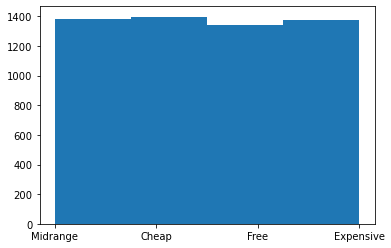

In [9]:
plt.hist(df1['price_range'], bins=4)
plt.show()

In [10]:
sys_req = df1[['release_year', 'pc_minimum', 'pc_recommended', 
               'mac_minimum', 'mac_recommended', 
               'linux_minimum', 'linux_recommend']]


# Data Overview & Understanding

## Game Attributes

In [11]:
def fill_col(df, punc):
    df = df.str.replace(' ', '')
    col_dict = df.apply(lambda x: x.split(punc)).apply(lambda y:{values: 1 for values in y}).values
    col_fill = pd.DataFrame(list(col_dict)).fillna(0)
    return col_fill

In [12]:
games_attributes = df1[['name', 'tags_cleaned', 'genre', 'categories']]
games_attributes

,name,tags_cleaned,genre,categories
0,Counter-Strike,Action;FPS;Multiplayer;Shooter;Classic;Team-Ba...,Action,Multi-player;Online Multi-Player;Local Multi-P...
1,Team Fortress Classic,Action;FPS;Multiplayer;Classic;Hero Shooter;Sh...,Action,Multi-player;Online Multi-Player;Local Multi-P...
2,Day of Defeat,FPS;World War II;Multiplayer;Shooter;Action;Wa...,Action,Multi-player;Valve Anti-Cheat enabled
3,Deathmatch Classic,Action;FPS;Classic;Multiplayer;Shooter;First-P...,Action,Multi-player;Online Multi-Player;Local Multi-P...
4,Half-Life: Opposing Force,FPS;Action;Classic;Sci-fi;Singleplayer;Shooter...,Action,Single-player;Multi-player;Valve Anti-Cheat en...
...,...,...,...,...
5484,Do Something,Zombies;Action;Survival Horror;Third Person;Hi...,"Action, Adventure",Single-player;Full controller support
5485,Deadly Racing Duel,Difficult;Rogue-like;Pixel Graphics;Singleplay...,Indie,Single-player
5486,Dungeon Crawler,Turn-Based Combat;Strategy;Dungeon Crawler;Hac...,"Casual, Indie, RPG, Strategy",Single-player
5487,AI Roguelite,Early Access;RPG;Text-Based;Visual Novel;Choos...,"Adventure, Indie, RPG, Early Access",Single-player


### Tags

,Number of Tags
tags,
Singleplayer,3830
Indie,3178
Action,3167
Adventure,2772
Multiplayer,2247
Casual,1742
Strategy,1709
RPG,1575
Atmospheric,1531


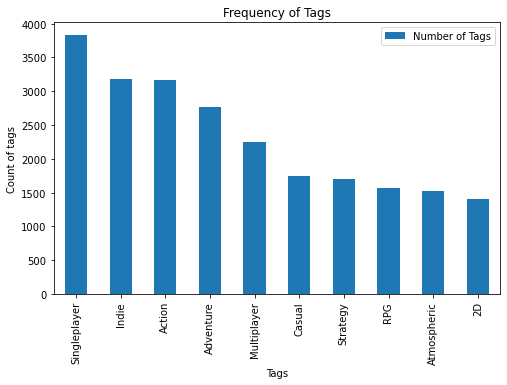

In [13]:
tags1 = fill_col(games_attributes['tags_cleaned'], ';')
tags1['name'] = games_attributes['name']

x = tags1
x.columns

tag_name = x.columns
tag_total = []
for value in tag_name:
    tag_total.append(tags1[tags1[value] == 1]['name'].count())
    
tags_data = {'Number of Tags': tag_total}
tags = pd.DataFrame(tags_data, index=tag_name)
tags.index.name = 'tags'

# display number on chart
tags_plot = tags.sort_values(by = 'Number of Tags', ascending = False).head(10)
display(tags_plot)
ax = tags_plot.plot.bar(figsize=(8,5))
ax.set_ylabel('Count of tags')
ax.set_xlabel('Tags')
ax.set_title('Frequency of Tags')
plt.show()

### Categories

,Number of Categories
categories,
Single-player,4877
SteamAchievements,3462
SteamTradingCards,2675
SteamCloud,2326
Multi-player,1757
Fullcontrollersupport,1598
PartialControllerSupport,954
Co-op,887
SteamLeaderboards,790


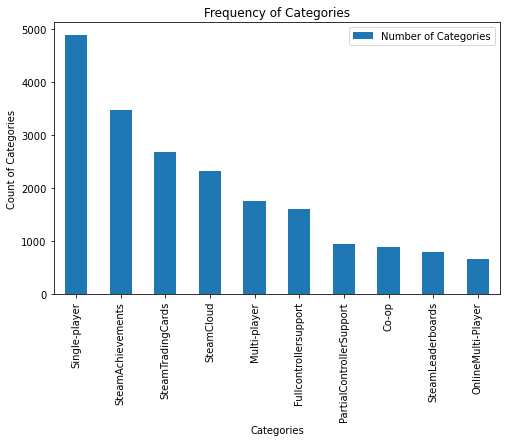

In [14]:
cat1 = fill_col(games_attributes['categories'], ';')
cat1['name'] = games_attributes['name']

x = cat1
x.columns

cat_names = x.columns
cat_total = []
for value in cat_names:
    cat_total.append(cat1[cat1[value] == 1]['name'].count())
    
cat_data = {'Number of Categories': cat_total}
cat_df = pd.DataFrame(cat_data, index=cat_names)
cat_df.index.name = 'categories'

# display number on chart
# data leakage?
cat_plot = cat_df.sort_values(by = 'Number of Categories', ascending = False).head(10)
display(cat_plot)
ax = cat_plot.plot.bar(figsize=(8,5))
ax.set_ylabel('Count of Categories')
ax.set_xlabel('Categories')
ax.set_title('Frequency of Categories')
plt.show()

### Genres

,Number of Genres
Genres,
Indie,3332
Action,2645
Adventure,2078
Strategy,1389
Casual,1319
RPG,1318
Simulation,1147
FreetoPlay,1007
MassivelyMultiplayer,421


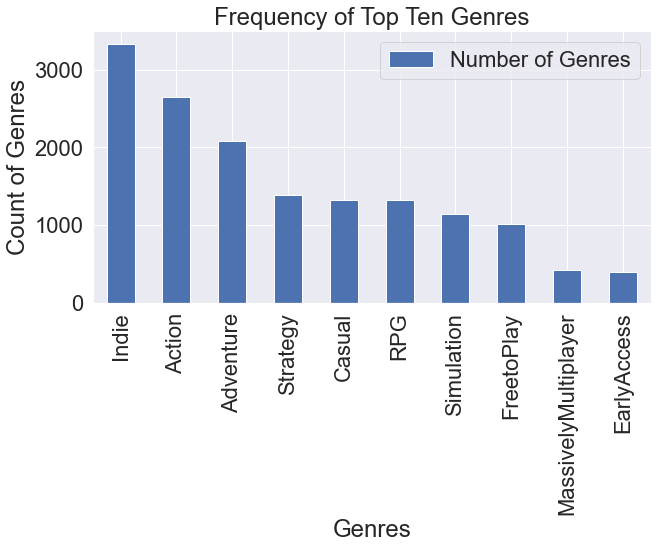

In [65]:
def fill_col(df):
    df = df.str.replace(' ', '')
    col_dict = df.apply(lambda x: x.split(';')).apply(lambda y:{values: 1 for values in y}).values
    col_fill = pd.DataFrame(list(col_dict)).fillna(0)
    return col_fill

genres = fill_col(df1['genre'])
genres[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'price']] = df1[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'price']]
first_column = genres.pop('name')
second_column = genres.pop('release_year')
genres.insert(0, 'name', first_column)
genres.insert(1,'release_year', second_column)

x = genres.iloc[:,2:-4]
x.columns

genre_name = x.columns
genre_total = []
for value in genre_name:
    genre_total.append(genres[genres[value] == 1]['price'].count())
    
top_genres_data = {'Number of Genres': genre_total}
top_genres = pd.DataFrame(top_genres_data, index=genre_name)
top_genres.index.name = 'Genres'

# display number on chart
# data leakage?
genre_plot = top_genres.sort_values(by = 'Number of Genres', ascending = False).head(10)
display(genre_plot)
ax = genre_plot.plot.bar(figsize=(10,5))
ax.set_ylabel('Count of Genres')
ax.set_xlabel('Genres')
ax.set_title('Frequency of Top Ten Genres')
plt.show()

In [16]:
df1.describe()

,appid,positive_ratings,negative_ratings,average_playtime,median_playtime,price,initialprice,discount,ccu,review_score,rating,owners_min,total_owners,release_year,total_ratings,max_revenue,min_revenue,over_500k
count,5.489000e+03,5.489000e+03,5489.000000,5489.000000,5489.000000,5489.000000,5489.000000,5489.000000,5489.000000,5489.000000,5489.000000,5.489000e+03,5.489000e+03,5489.000000,5.489000e+03,5.489000e+03,5.489000e+03,5489.000000
mean,5.563665e+05,1.104476e+04,1732.639096,804.126799,645.230097,10.791833,1129.433777,3.280561,1145.061213,0.784485,75.478047,5.838404e+05,1.276899e+06,2016.062489,1.277740e+04,1.566121e+07,7.127716e+06,0.628894
std,3.993958e+05,8.892974e+04,16971.878287,3326.912081,4326.955947,12.229968,1247.072675,14.915249,18488.494710,0.160985,14.485300,2.392919e+06,5.069732e+06,3.391744,1.026944e+05,8.717276e+07,3.997947e+07,0.483145
min,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05,2.000000e+05,1997.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.724700e+05,5.220000e+02,134.000000,93.000000,68.000000,0.540000,99.000000,0.000000,1.000000,0.700000,67.000000,1.000000e+05,2.000000e+05,2014.000000,7.270000e+02,1.980000e+05,9.900000e+04,0.000000
50%,4.371600e+05,1.660000e+03,318.000000,243.000000,224.000000,7.490000,999.000000,0.000000,11.000000,0.830000,79.000000,2.000000e+05,5.000000e+05,2016.000000,2.109000e+03,2.495000e+06,9.990000e+05,1.000000
75%,7.733700e+05,5.004000e+03,867.000000,597.000000,441.000000,15.000000,1999.000000,0.000000,88.000000,0.910000,87.000000,5.000000e+05,1.000000e+06,2019.000000,6.068000e+03,9.980000e+06,3.998000e+06,1.000000
max,1.903490e+06,5.559446e+06,876946.000000,120223.000000,225183.000000,99.990000,9999.000000,90.000000,862238.000000,1.000000,98.000000,1.000000e+08,2.000000e+08,2022.000000,6.302487e+06,3.999000e+09,1.999500e+09,1.000000


In [17]:
# CAT = ['type', 'name', 'appid', 'is_free', 'detailed_description', 'about_the_game', 
#       'short_description','platforms', 'categories','developer', 
#       'publisher','languages','genre','tags']


CAT = df1.select_dtypes(include= ['object', 'category', 'bool'])
NUM = df1.select_dtypes(include= [np.number, 'datetime64'])

In [18]:
NUM.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,appid,positive_ratings,negative_ratings,average_playtime,median_playtime,price,initialprice,discount,ccu,review_score,rating,owners_min,total_owners,release_year,total_ratings,max_revenue,min_revenue,over_500k
count,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000
mean,556366.46457,11044.76389,1732.63910,804.12680,645.23010,10.79183,1129.43378,3.28056,1145.06121,0.78449,75.47805,583840.40809,1276899.25305,2016.06249,12777.40299,15661214.97541,7127715.79523,0.62889
std,399395.84583,88929.74369,16971.87829,3326.91208,4326.95595,12.22997,1247.07267,14.91525,18488.49471,0.16099,14.48530,2392919.45716,5069731.87386,3.39174,102694.44026,87172763.32838,39979467.56420,0.48314
min,10.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100000.00000,200000.00000,1997.00000,0.00000,0.00000,0.00000,0.00000
25%,272470.00000,522.00000,134.00000,93.00000,68.00000,0.54000,99.00000,0.00000,1.00000,0.70000,67.00000,100000.00000,200000.00000,2014.00000,727.00000,198000.00000,99000.00000,0.00000
50%,437160.00000,1660.00000,318.00000,243.00000,224.00000,7.49000,999.00000,0.00000,11.00000,0.83000,79.00000,200000.00000,500000.00000,2016.00000,2109.00000,2495000.00000,999000.00000,1.00000
75%,773370.00000,5004.00000,867.00000,597.00000,441.00000,15.00000,1999.00000,0.00000,88.00000,0.91000,87.00000,500000.00000,1000000.00000,2019.00000,6068.00000,9980000.00000,3998000.00000,1.00000
max,1903490.00000,5559446.00000,876946.00000,120223.00000,225183.00000,99.99000,9999.00000,90.00000,862238.00000,1.00000,98.00000,100000000.00000,200000000.00000,2022.00000,6302487.00000,3999000000.00000,1999500000.00000,1.00000


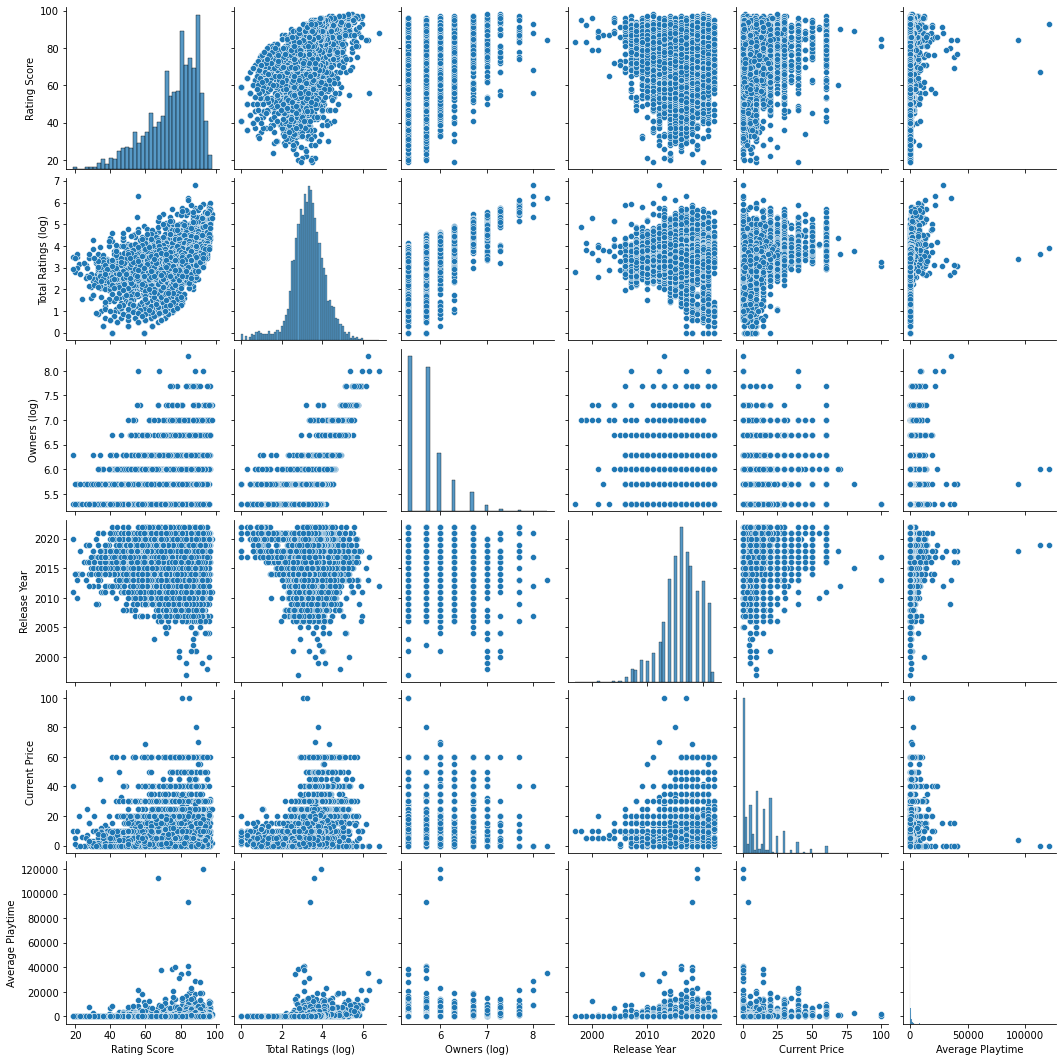

In [19]:
df = df1[(df1['total_owners'] > 0) & (df1['total_ratings'] > 0)].copy()
eda = pd.DataFrame(zip(df['rating'], 
                            np.log10(df['total_ratings']), 
                            np.log10(df['total_owners']), 
                            df['release_year'], 
                            df.price,
                            df['average_playtime']),
                       columns = ['Rating Score', 'Total Ratings (log)', 'Owners (log)', 
                                  'Release Year', 'Current Price', 'Average Playtime'])
sns.pairplot(eda)
plt.show()

### Number of Games Released

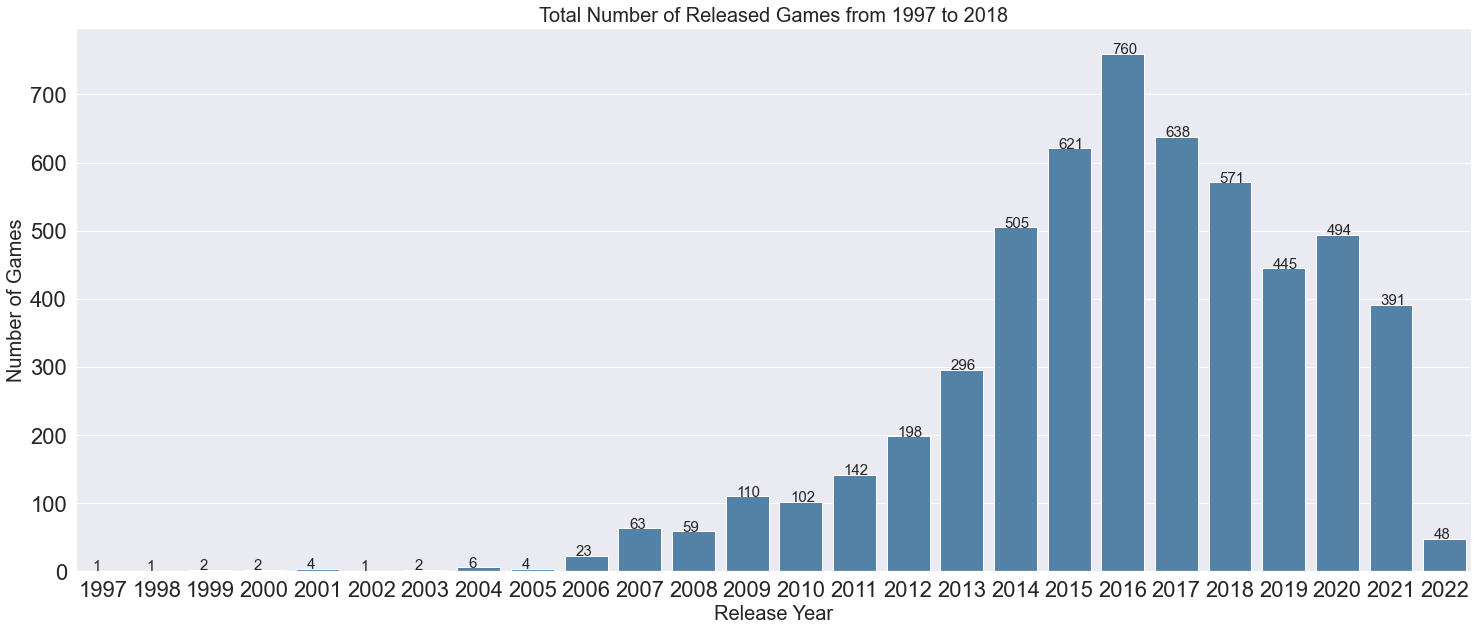

In [20]:
# Provide User Count 500k
plt.figure(figsize=(25,10))
sns.set_theme(style = 'darkgrid', font_scale = 2)
ax = sns.countplot(x=df1['release_year'],data=df1, color= 'steelblue')
plt.title('Total Number of Released Games from 1997 to 2018', fontsize = 20)
plt.ylabel('Number of Games', fontsize = 20)
plt.xlabel('Release Year', fontsize = 20)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), size=15)
    
plt.show()

<AxesSubplot:xlabel='total_owners', ylabel='count'>

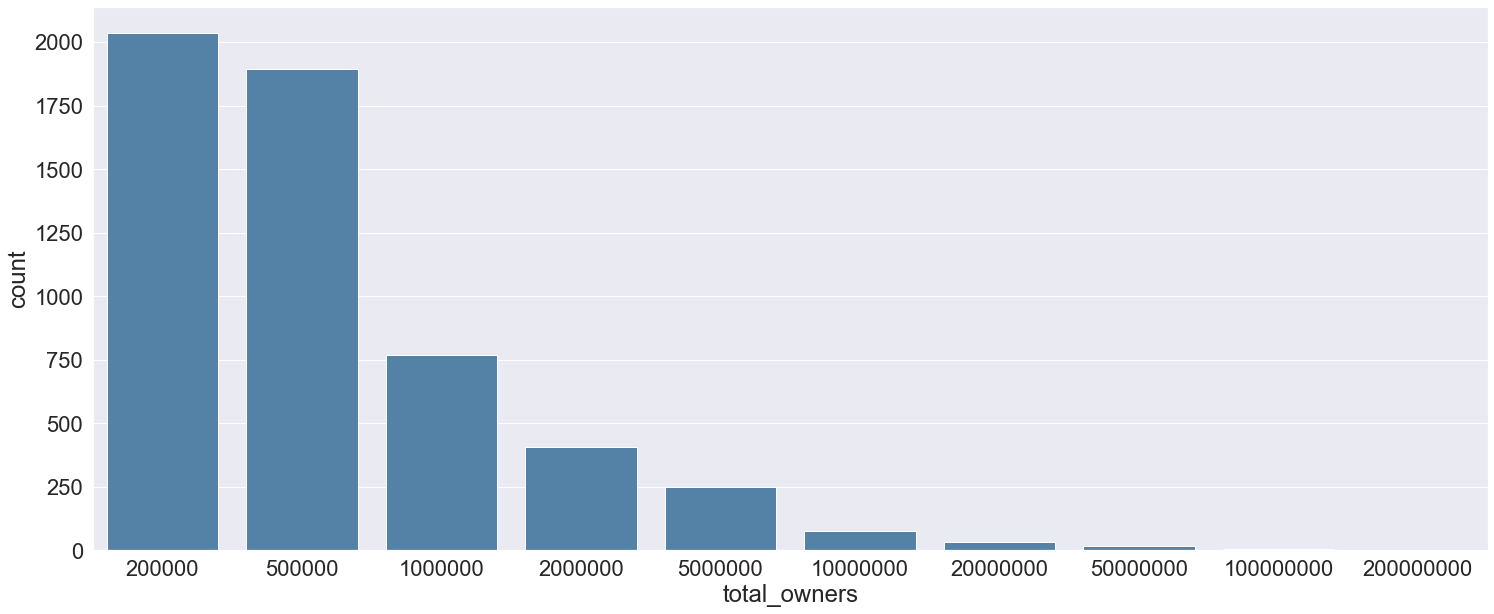

In [21]:
plt.figure(figsize=(25,10))
sns.countplot(x=df1['total_owners'],data=df1, color= 'steelblue')

### Top 10 Rated Games

In [22]:
df_games = df1[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'price']]
display(df_games.sort_values(by = 'rating', ascending = False).head(10))

,name,release_year,average_playtime,total_owners,rating,price
23,Portal 2,2011,875,20000000,98.0,1.99
4186,Hades,2020,1767,10000000,98.0,24.99
2469,Stardew Valley,2016,3404,20000000,97.0,14.99
4220,Helltaker,2020,153,5000000,97.0,0.00
4027,Bloons TD 6,2018,2779,5000000,97.0,9.99
4126,Half-Life: Alyx,2020,642,5000000,97.0,59.99
4181,People Playground,2019,2139,5000000,97.0,9.99
17,Portal,2007,282,20000000,97.0,9.99
2584,Wallpaper Engine,2018,3407,20000000,97.0,3.99
2551,Factorio,2016,6144,10000000,97.0,30.00


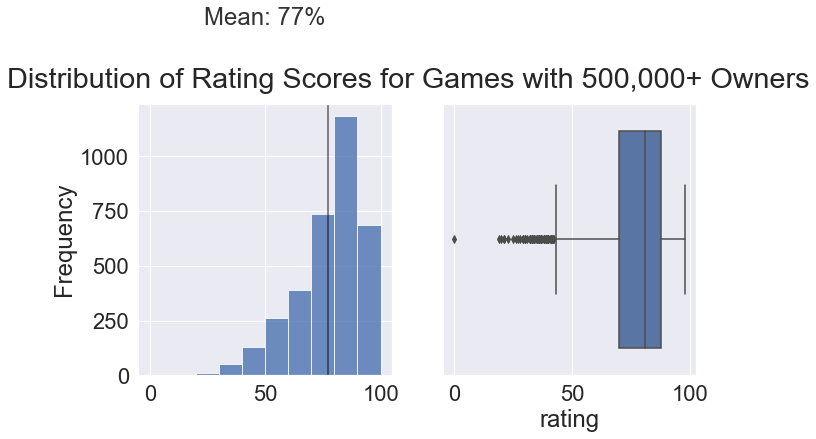

Mean rating: 77.20%


In [23]:
# over 500000 owners
df = df1[(df1.total_owners >= 500000)].copy()

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df.rating.plot.hist(range=(0, 100), bins=10, ax=axarr[0], alpha=.8)

# plotting line for mean on histogram
mean = df.rating.mean()
axarr[0].axvline(mean, c='black', alpha=.6)
axarr[0].text(mean-1, 1600, f'Mean: {mean:.0f}%', c='black', ha='right', alpha=.8)


ax = sns.boxplot(x='rating', data=df, orient='v', ax=axarr[1])
fig.suptitle('Distribution of Rating Scores for Games with 500,000+ Owners')
plt.show()

print(f'Mean rating: {df.rating.mean():.2f}%')

### Top 10 Most Owned Games

In [48]:
top_owned = display(df_games.sort_values(by = 'total_owners', ascending = False).head(10))

,name,release_year,average_playtime,total_owners,rating,price
22,Dota 2,2013,35483,200000000,84.0,0.00
19,Team Fortress 2,2007,9470,100000000,93.0,0.00
4172,New World,2021,9088,100000000,68.0,39.99
4128,PUBG: BATTLEGROUNDS,2017,21824,100000000,56.0,0.00
25,Counter-Strike: Global Offensive,2012,28940,100000000,88.0,0.00
4014,Among Us,2018,1226,50000000,91.0,4.99
4173,Destiny 2,2019,7857,50000000,83.0,0.00
1483,Brawlhalla,2017,2050,50000000,83.0,0.00
4208,Halo Infinite,2021,836,50000000,75.0,0.00
4209,ELDEN RING,2022,4308,50000000,87.0,59.99


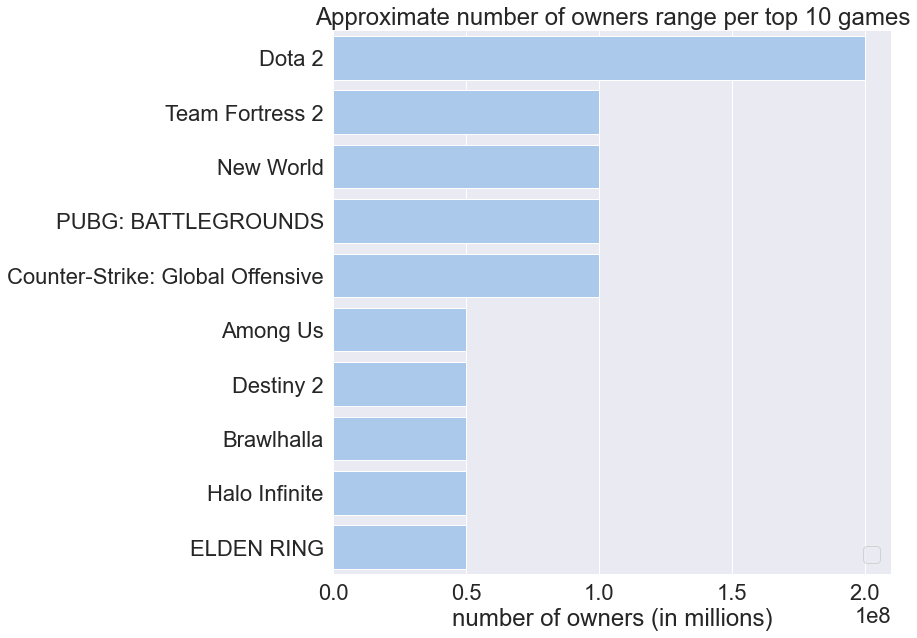

In [63]:
# Plot top 10 games by owners
f, ax = plt.subplots(figsize=(10,10))

df_sorted_owners = df1.sort_values('total_owners', ascending=False).head(10)

sns.set_color_codes("pastel")
sns.barplot(x='total_owners', y="name", data=df_sorted_owners, color="b")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], ncol=2, loc="lower right", frameon=True)
ax.set(
    xlabel="number of owners (in millions)",
    ylabel="",
    title="Approximate number of owners range per top {} games".format(10)
)
sns.despine(left=True, bottom=True)

### Top 10 Most Played Games

In [26]:
display(df_games.sort_values(by = 'average_playtime', ascending = False).head(10))

,name,release_year,average_playtime,total_owners,rating,price
4385,NGU IDLE,2019,120223,1000000,93.0,0.00
4354,Lords Mobile,2019,112846,1000000,67.0,0.00
3832,SAO Utils: Beta,2018,93530,500000,84.0,3.99
2800,Idling to Rule the Gods,2016,40974,500000,84.0,0.00
3738,Trailer Park Boys: Greasy Money,2018,40516,500000,77.0,0.00
3069,RutonyChat,2016,38274,200000,75.0,14.99
3958,Cadria Item Shop,2018,37855,500000,69.0,0.00
22,Dota 2,2013,35483,200000000,84.0,0.00
245,Hearts of Iron 2 Complete,2009,34494,200000,80.0,14.99
3181,Onmyoji,2018,31604,500000,79.0,0.00


#### Which years had the highest playtime average?

<AxesSubplot:xlabel='release_year', ylabel='average_playtime'>

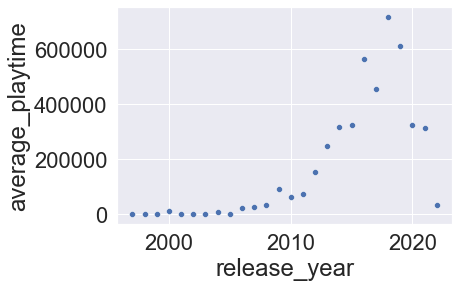

In [27]:
average_play = df_games.groupby(by = 'release_year').average_playtime.sum().sort_values(ascending = False)#.head(10)
average_play_df = pd.DataFrame(average_play)
sns.scatterplot(x='release_year', y='average_playtime', data=average_play_df)

In [28]:
df1.columns

Index(['type', 'name', 'appid', 'required_age', 'platforms', 'categories',
       'release_date', 'developer', 'publisher', 'positive_ratings',
       'negative_ratings', 'owners', 'average_playtime', 'median_playtime',
       'price', 'initialprice', 'discount', 'languages', 'genre', 'ccu',
       'tags', 'review_score', 'rating', 'owners_min', 'total_owners',
       'tags_cleaned', 'multiplayer', 'singleplayer', 'pc_minimum',
       'pc_recommended', 'mac_minimum', 'mac_recommended', 'linux_minimum',
       'linux_recommend', 'release_year', 'total_ratings', 'max_revenue',
       'min_revenue', 'over_500k', 'price_range'],
      dtype='object')

In [29]:
languages = fill_col(df1['languages'])
languages[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'languages']] = df1[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'languages']]
first_column = languages.pop('name')
second_column = languages.pop('release_year')
languages.insert(0, 'name', first_column)
languages.insert(1,'release_year', second_column)

In [30]:
languages.columns

Index(['name', 'release_year', 'English', 'French', 'German', 'Italian',
       'Spanish-Spain', 'SimplifiedChinese', 'TraditionalChinese', 'Korean',
       'Russian', 'Dutch', 'Danish', 'Finnish', 'Japanese', 'Norwegian',
       'Polish', 'Portuguese', 'Swedish', 'Thai', 'Turkish', 'Czech',
       'Hungarian', 'Portuguese-Brazil', 'Greek', 'Bulgarian', 'Romanian',
       'Ukrainian', 'Spanish-LatinAmerica', 'Vietnamese', 'Slovakian',
       'Arabic', 'Unknown', 'Notsupported', 'average_playtime', 'total_owners',
       'rating', 'languages'],
      dtype='object')

,Number of Supported Languages
Languages,
English,5461
German,2944
French,2880
Spanish-Spain,2668
Russian,2488
Italian,2196
SimplifiedChinese,1963
Japanese,1794
Portuguese-Brazil,1497


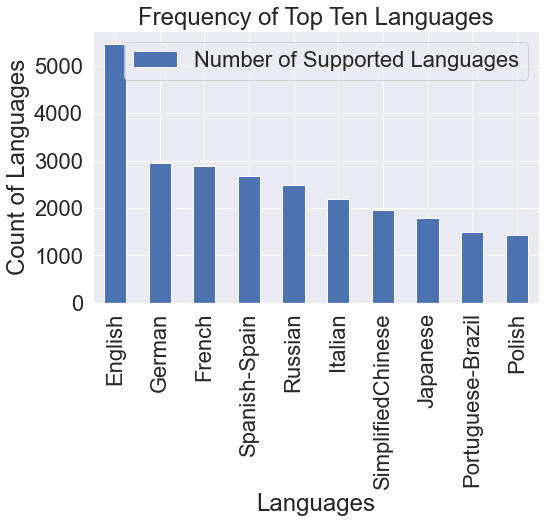

In [31]:
x = languages.iloc[:,2:-4]
x.columns

lang_type = x.columns
lang_total = []
for value in lang_type:
    lang_total.append(languages[languages[value] == 1]['name'].count())
    
lang_data = {'Number of Supported Languages': lang_total}
top_languages = pd.DataFrame(lang_data, index=lang_type)
top_languages.index.name = 'Languages'

# display number on chart
# data leakage?
lang_plot = top_languages.sort_values(by = 'Number of Supported Languages', ascending = False).head(10)
display(lang_plot)
ax = lang_plot.plot.bar(figsize=(8,5))
ax.set_ylabel('Count of Languages')
ax.set_xlabel('Languages')
ax.set_title('Frequency of Top Ten Languages')
plt.show()

## Platforms

In [32]:
def fill(df):
    df = df.str.replace(' ', '')
    col_dict = df.apply(lambda x: x.split(';')).apply(lambda y:{values: 1 for values in y}).values
    col_fill = pd.DataFrame(list(col_dict)).fillna(0)
    return col_fill

,Number of Supported Platforms
Platforms,
windows,5489
mac,2065
linux,1430


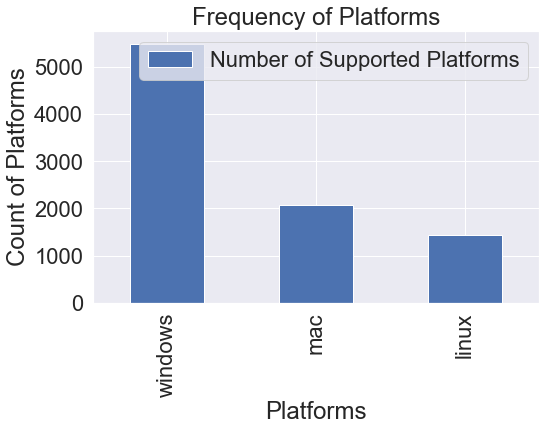

In [33]:
platforms = fill(df1['platforms'])
platforms[['name', 'release_year', 'average_playtime', 
           'total_owners', 'rating', 'platforms']] = df1[['name', 'release_year', 'average_playtime', 
                                                        'total_owners', 'rating', 'platforms']]
first_column = platforms.pop('name')
second_column = platforms.pop('release_year')
platforms.insert(0, 'name', first_column)
platforms.insert(1,'release_year', second_column)

x = platforms
x.columns[2:5]

platform_type = x.columns
platform_total = []
for value in platforms:
    platform_total.append(platforms[platforms[value] == 1]['name'].count())
    
platform_data = {'Number of Supported Platforms': platform_total}
top_platforms = pd.DataFrame(platform_data, index= platform_type)
top_platforms.index.name = 'Platforms'

# display number on chart
# data leakage?
platforms_plot = top_platforms.sort_values(by = 'Number of Supported Platforms', ascending = False).head(3)
display(platforms_plot)
ax = platforms_plot.plot.bar(figsize=(8,5))
ax.set_ylabel('Count of Platforms')
ax.set_xlabel('Platforms')
ax.set_title('Frequency of Platforms')
plt.show()

## Categorial vs. Numerical Variables

In [34]:
def make_scatterplot_feature(TARGET1, TARGET2):
    TARGET = TARGET1, TARGET2
    X_VALS = [x_col for x_col in NUM.columns if x_col != TARGET]
    
    for x in X_VALS:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,3))
        sns.scatterplot(x=x, y=TARGET1, data=NUM, ax=ax1)#.set(title=f'Price by {X_VALS}')
        sns.scatterplot(x=x, y=TARGET2, data=NUM, ax=ax2)
        # fig.tight_layout()
        plt.show()
    
    return 

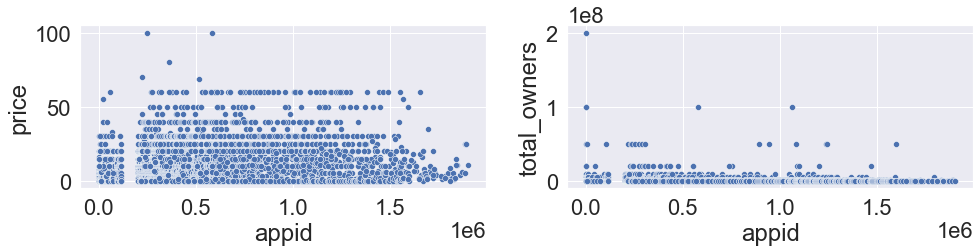

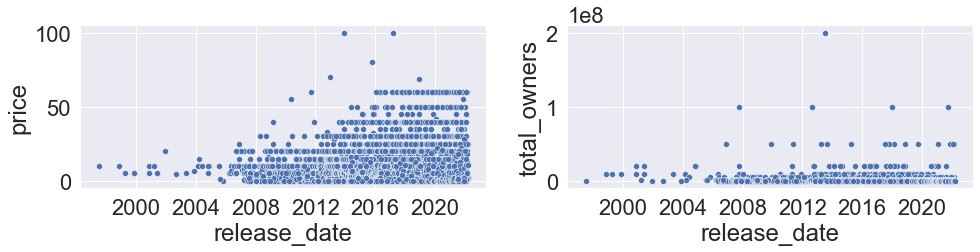

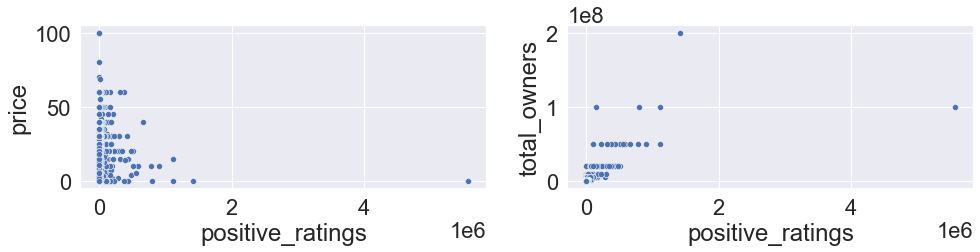

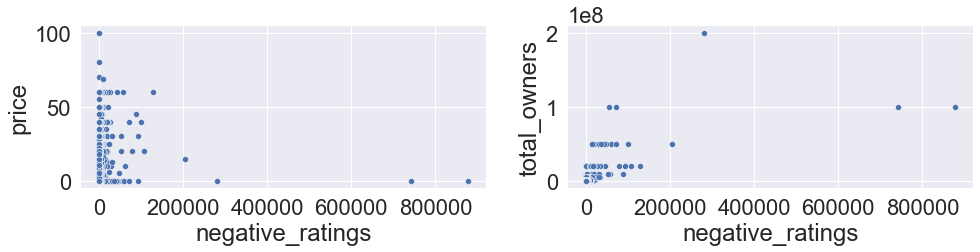

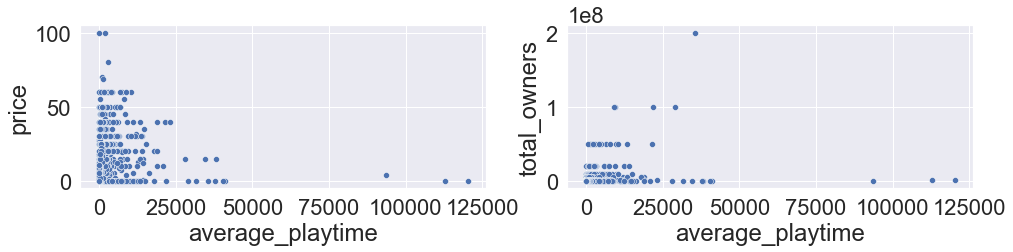

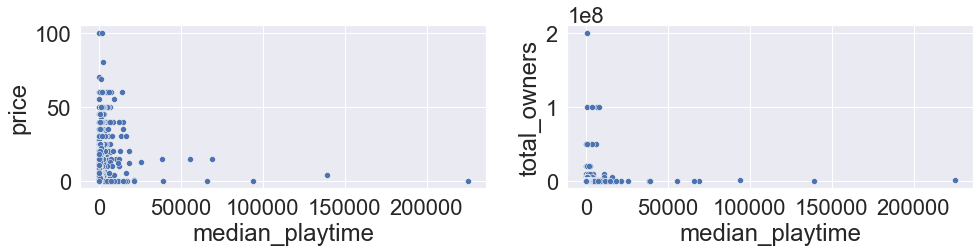

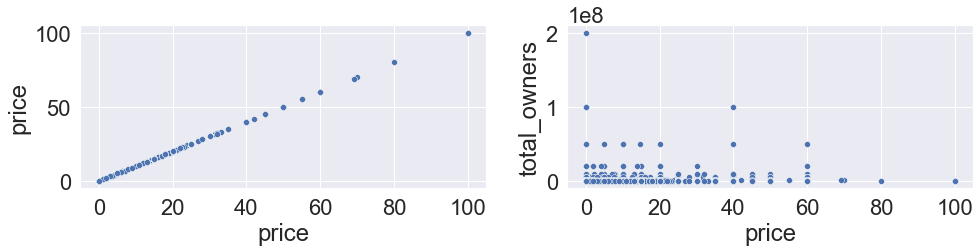

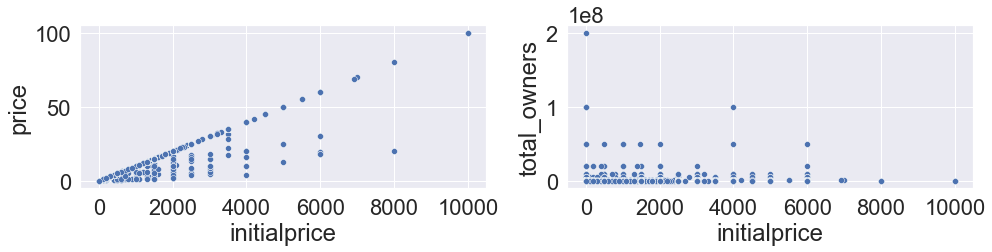

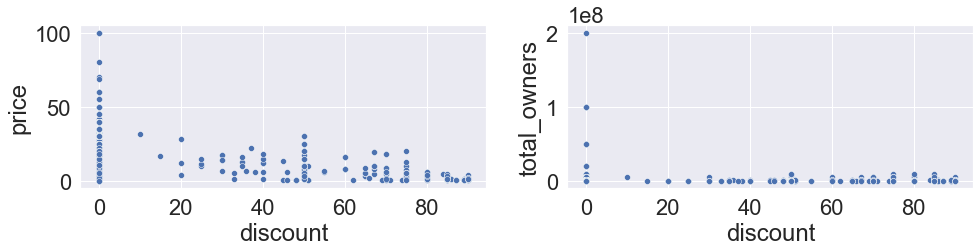

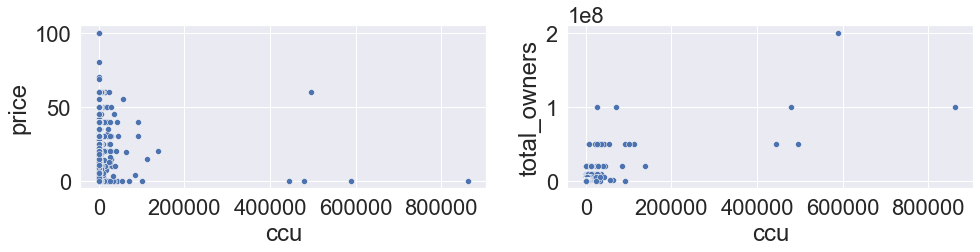

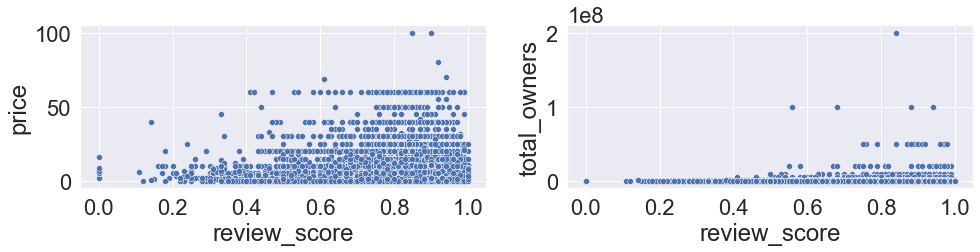

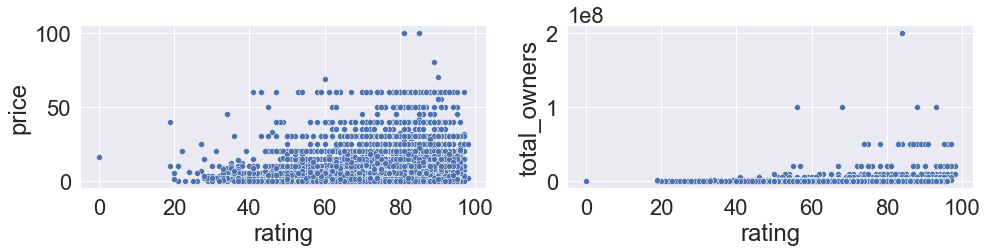

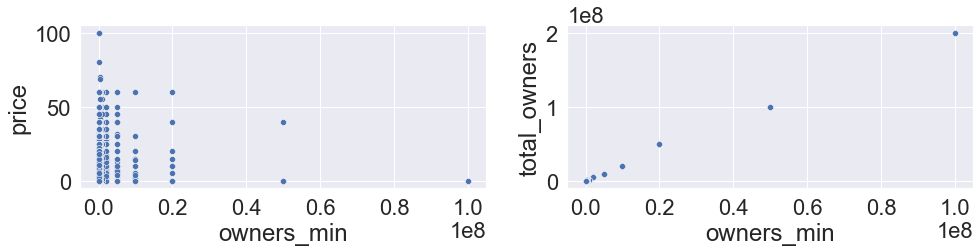

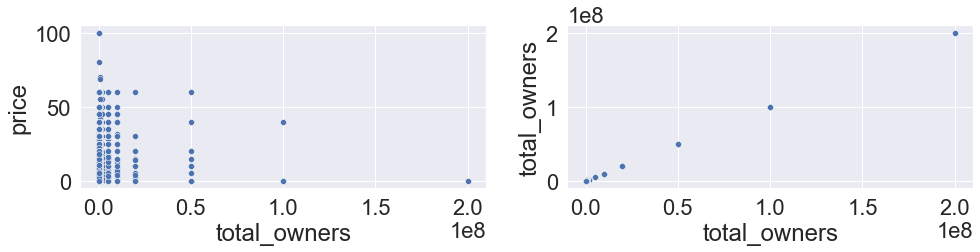

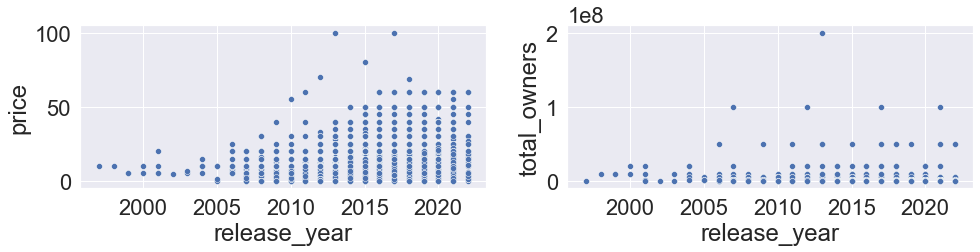

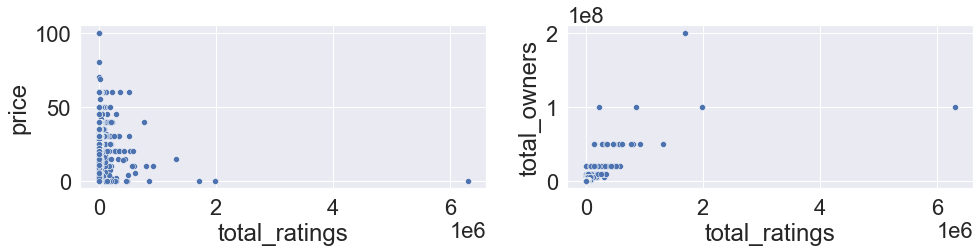

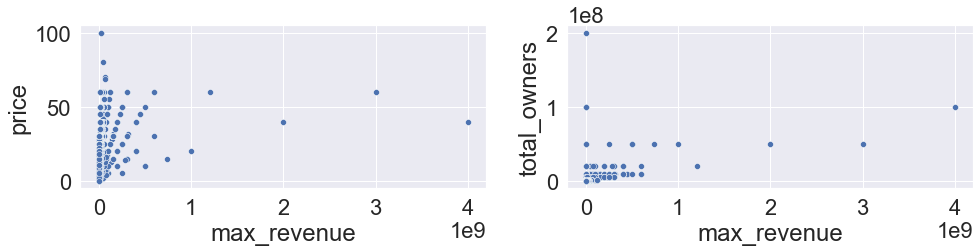

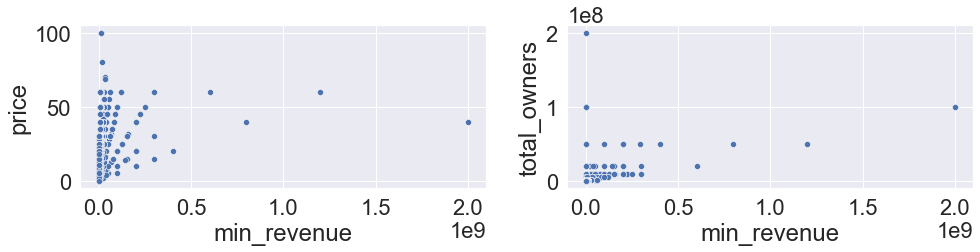

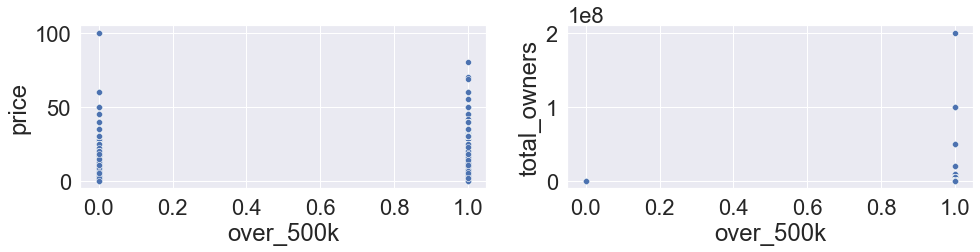

In [35]:
make_scatterplot_feature('price', 'total_owners')

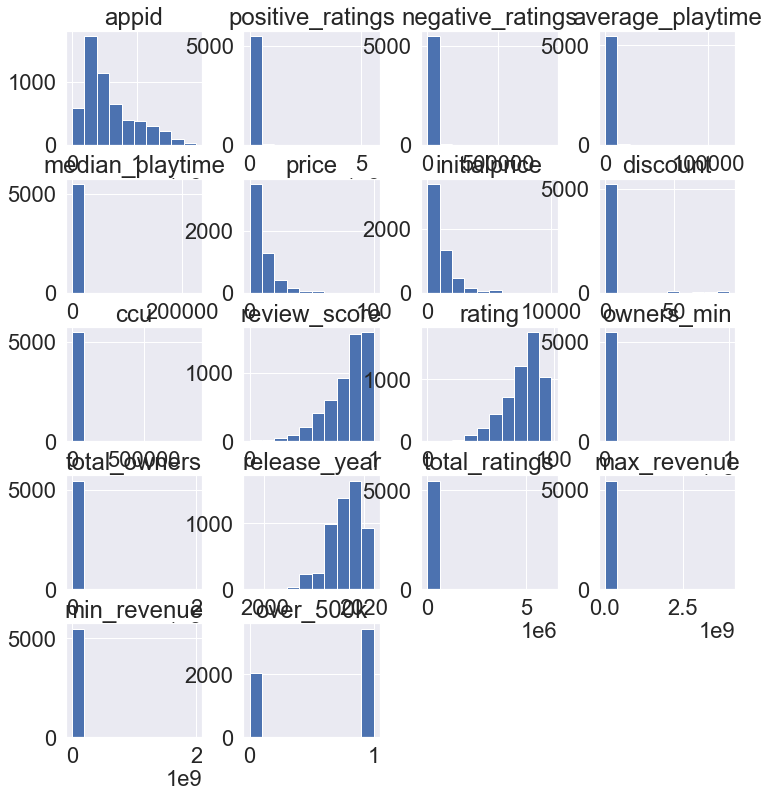

In [36]:
NUM.hist(figsize=(12,13));

In [37]:
tags = df1['tags_cleaned'].str.get_dummies(';')
df1 = pd.concat([df1,tags], axis=1)

In [38]:
df1

,type,name,appid,required_age,platforms,categories,release_date,developer,publisher,positive_ratings,...,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,game,Counter-Strike,10,All Ages,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,2000-11-01,Valve,Valve,194508,...,0,0,0,0,0,0,0,0,0,1
1,game,Team Fortress Classic,20,All Ages,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,1999-04-01,Valve,Valve,5485,...,0,0,0,0,0,0,0,0,0,0
2,game,Day of Defeat,30,All Ages,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,2003-05-01,Valve,Valve,5052,...,0,0,0,0,0,1,1,0,0,0
3,game,Deathmatch Classic,40,All Ages,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,2001-06-01,Valve,Valve,1876,...,0,0,0,0,0,0,0,0,0,0
4,game,Half-Life: Opposing Force,50,All Ages,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,1999-11-01,Gearbox Software,Valve,13557,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,game,Do Something,1810240,All Ages,windows,Single-player;Full controller support,2021-12-15,StrelitziaGames,StrelitziaGames,3,...,0,0,0,0,0,0,0,0,1,0
5485,game,Deadly Racing Duel,1842410,All Ages,windows,Single-player,2022-01-31,DDRACE,kovalevviktor,9,...,0,0,0,0,0,0,0,0,0,0
5486,game,Dungeon Crawler,1873960,All Ages,windows,Single-player,2022-02-25,Jinxi,Jinxi,5,...,0,0,0,0,0,0,0,0,1,0
5487,game,AI Roguelite,1889620,All Ages,windows,Single-player,2022-03-02,Max Loh,Max Loh,4,...,0,0,0,0,0,0,0,0,1,0


In [39]:
def cat_gen_tag(df):
    """Clean and process Categories, Genres, and Tags"""

    df1['genre'] = df1['genre'].str.replace(' ', '').str.replace(',', ';')
    genres = df1['genre'].str.get_dummies(';')
    col_names = genres.mean()[genres.mean() > 0.01].sort_values(ascending=False).keys()
    df = pd.concat([df1,genres[col_names]], axis=1)
    
    cat = df1['categories'].str.get_dummies(';')
    df = pd.concat([df1, cat], axis=1)
    
    df1['tags_cleaned'] = df1['tags_cleaned'].str.replace(' ', '')
    tags = df1['tags_cleaned'].str.get_dummies(';')
    tags.drop(columns = col_names, axis = 1)
    df = pd.concat([df1,tags], axis=1)

    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df.drop(['categories', 'tags', 'tags_cleaned', 'genre'], axis=1, inplace = True)
    
    return df
    

In [40]:
def platforms(df):
    platforms = df1['platforms'].str.get_dummies(';')
    df = pd.concat([df1,platforms], axis = 1)
    
    return df

def required_age(df):
    age = df1['required_age'].str.get_dummies()
    df = pd.concat([df1,age], axis = 1)
    
    return df

def price_range(df):
    price = df1['price_range'].str.get_dummies()
    df = pd.concat([df1,price], axis = 1)
    
    return df

def language(df):
    language = df1['languages'].str.get_dummies(',')
    df = pd.concat([df1,language], axis = 1)
    
    return df

In [41]:
def multi_label(df):
    
    df = cat_gen_tag(df)
    df = platforms(df)
    df = required_age(df)
    df = price_range(df)
#    df = language(df)
    
    return df
    
df2 = multi_label(df1)

In [47]:
df2.shape

(5489, 467)

In [42]:
GAMEATT = df2.iloc[:,40:-1]
GAMEATT

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,...,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports,Cheap,Expensive,Free
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
5485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [43]:
df2.to_csv('data/steam_preprocessed.csv', index=False)

In [44]:
# make heatmap

In [45]:
# model

In [46]:
# results 